# Model Inversion Attack 

The objective of a **Model Inversion Attack** is to recover information about the data the model was trained on, or outright data samples. The model in question is referred to as a **Target Model** and is a so-called *Black-Box Model* since we don't have information about its architecture, its parameters, the way it was trained and the data used. We do however have access to its prediction function; we can access it through an API Query for instance.

Based on the purpose of this target model, we can infer the type of data it was used on. For instance, a model that is used to predict if an image is a dog or a hotdog was trained on samples of dogs and hotdogs. Note that it is certainly not necessary to have the exact same training set. So we can use any creative data collection technique to gather a dataset of a similar distribution to the supposed training set.

Now the pipeline of this attack is the following: first, we collect data samples and then we send requests to the Target Model to record the predictions made. Finally, we train an **Attack Model** to reconstruct images given the output of the target model. In other words, the input to the Attack Model is a Tensor of size *m* (where m is the number of classes/outputs of the Target Model) and its output is another tensor of size (n, n, 3) where is the size of the original image fed to the Target Model. In other words, we build have an Encoder-Decoder architecture, where the encoder is the Target Model and the decoder is our Attack Model.

The final step of the model inversion attack is the data recovery stage: we query the Attack model with made up tensors. Those tensors can be either a one hot-encoded for a specific class, in which case the Attack Model will return the image that is most likely to be predicted for each of the *m* dimensions of the model.

In this notebook, we will query an API created for the competition [AI Village Capture the Flag @ DEFCON](https://www.kaggle.com/competitions/ai-village-ctf?rvi=1), specifically the *Inference Challenge*. The objective is to recover a 6 one letter images that activate the classes of the Target Model. Knowing that the training data was letters, we can use a dataset of handwritten letters. The architecture of the pipeline will once again be a Target Model that takes images as input classifies/encodes then in 6 classes/dimensions and an Attack Model that takes the 6 dimensional data and upscales them to the original images.

This Pytorch Implementation is inspired by [OpenMined](https://github.com/OpenMined/PySyft/blob/a27deed0d07c199de039fafd323164640c9c8f6d/examples/tutorials/advanced/privacy_attacks/Tutorial%201%20-%20Black%20box%20model%20inversion.ipynb).

In [1]:
import numpy as np
import requests
import json
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tqdm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange
from torch.optim.lr_scheduler import StepLR

! pip install torchsummary 
from torchsummary import summary

## Data Processing

In [2]:
# Image processing
# This steps is only needed because the EMNIST Dataset used has flipped images
mnist_transform = transforms.Compose(
    [
        lambda img: transforms.functional.rotate(img, -90),
        lambda img: transforms.functional.hflip(img),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# Get dataset
attacker_dataset_train = EMNIST("emnist", 'balanced', download=True, train=True, transform=mnist_transform)
attacker_dataset_test = EMNIST("emnist", 'balanced', download=True, train=False, transform=mnist_transform)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [3]:
# Remove lower case letters
attacker_dataset_train.data = attacker_dataset_train.data[attacker_dataset_train.targets <= 35]
attacker_dataset_train.targets = attacker_dataset_train.targets[attacker_dataset_train.targets <= 35]

attacker_dataset_test.data = attacker_dataset_test.data[attacker_dataset_test.targets <= 35]
attacker_dataset_test.targets = attacker_dataset_test.targets[attacker_dataset_test.targets <= 35]

# Keep fewer samples (to reduce execution time of label collection)
attacker_dataset_train.data = attacker_dataset_train.data[:10000]
attacker_dataset_train.targets = attacker_dataset_train.targets[:10000]

attacker_dataset_test.data = attacker_dataset_test.data[:100]
attacker_dataset_test.targets = attacker_dataset_test.targets[:100]

In [4]:
# Dataloader
attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=64)
attacker_loader_test = torch.utils.data.DataLoader(attacker_dataset_test, batch_size=64)

In [5]:
def plot_images(tensors):
    """ Plot normalised MNIST images """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = n_tensors
    n_rows = 1

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = tensors[idx]

            # Clip image values
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            # Put the channel last
            tensor = torch.permute(tensor, (1, 2, 0))

            ax.imshow(tensor)

    plt.tight_layout()
    plt.show()

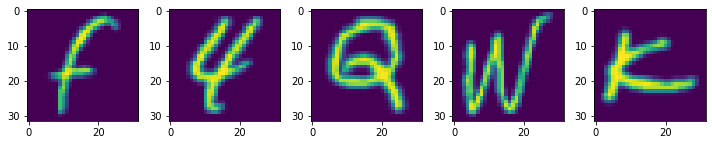

In [6]:
def plot_data(data_loader):
    """ Plot data used to supposedly train the target model """
    images = []

    for _, (data, _) in enumerate(data_loader):
        for i in range(5):
            images.append(data[i])

        break

    plot_images(images)

plot_data(attacker_loader_train)

## Target Model

Build a PyTorch Model that queries the API as its prediction step.

In [7]:
## Target model
class TargetModel(torch.nn.Module):
    def forward(self, x):

        # Put the channel last
        x = torch.permute(x, (0, 2, 3, 1))

        # Query the Target Model to get a confidence score
        try:
            response = requests.post("https://inference.fly.dev/score", data = json.dumps({"input": x.tolist()}))
            res = json.loads(response.text)
        except requests.exceptions.ConnectionError:
            print("Connection problems. Contact the CTF organizers.")

        return np.array(res['outputs'])

# Get target
target_model = TargetModel()

In [8]:
def get_target_labels(loader):
    """ Gather data labels from the target model """
    attacker_targets = []

    for data, label in tqdm(loader):
        data.float()

        with torch.no_grad():
            attacker_targets.append(target_model(data))

    return torch.tensor(np.concatenate(attacker_targets))

attacker_targets_train = get_target_labels(attacker_loader_train)
attacker_targets_test = get_target_labels(attacker_loader_test)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Saved it for you to reuse it ;)
np.savez('./labels_train.npz', attacker_targets_train.numpy())
np.savez('./labels_test.npz', attacker_targets_test.numpy())

In [10]:
def reconstruct_samples(model):
    """ Visualize the model's capacity to reconstruct the original image based on the Target model output """
    images = []

    for batch, (data, _) in enumerate(attacker_loader_train):
        # Take the model output intercepted from the target model
        # For train data
        targets = attacker_targets_train[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        for i in range(2):

            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0).cuda()).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    for batch, (data, _) in enumerate(attacker_loader_test):
        # Take the model output intercepted from the target model
        # For test data
        targets = attacker_targets_test[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        for i in range(2):

            with torch.no_grad():
                reconstructed_image = model(torch.unsqueeze(targets[i], 0).cuda()).squeeze(0)

            images.append(data[i])
            images.append(reconstructed_image.cpu())
        break

    plot_images(images)

## Attack Model

An inversion attack is easiest when the ratio of input size (in other words the number outputs of the target model) to output size (in other words the size of the original image) is high. In our case we upscale a tensor of size 6 into an image of size (32x32).

In [11]:
## Attack Model
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(6, 16*16*4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (4, 16, 16)),
            torch.nn.ConvTranspose2d(
                in_channels=4,
                out_channels=1,
                kernel_size=3,
                padding=1,
                stride=2,
                output_padding=1),
        )

    def forward(self, x):
        return self.layers(x)

# Get attacker
attacker = AttackModel().cuda()
summary(attacker, (6, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]           7,168
              ReLU-2                 [-1, 1024]               0
         Unflatten-3            [-1, 4, 16, 16]               0
   ConvTranspose2d-4            [-1, 1, 32, 32]              37
Total params: 7,205
Trainable params: 7,205
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.03
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [12]:
def attack(attack_model):
    """ For the 6 output classes of the model, get its reconstructed train data sample """
    images = []

    for idx in range(6):
        target_output = np.zeros(6)
        target_output[idx] = 1

        with torch.no_grad():
            reconstructed_image = attack_model(torch.tensor([target_output]).float().cuda()).squeeze(0)

        images.append(reconstructed_image.cpu())

    plot_images(images)

## Inversion Attack

Now onto the training of the Attack Model. The most critical part is the Loss function. **I minimize the Euclidian distance between the original image (fed to the Target Model) and the reconstructed image.**

I did not use any data augmentation because the assumption that the attack model should be robust to a small transform to the original image (fed to the target model) is quite strong. Since we don't know much about the dataset used, I figured it was dangerous but do let me know if that is wise.

  0%|          | 0/100 [00:00<?, ?it/s]

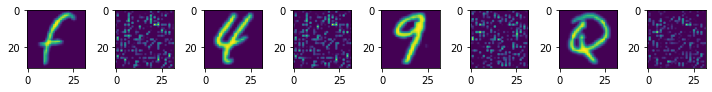

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  # Remove the CWD from sys.path while we load stuff.


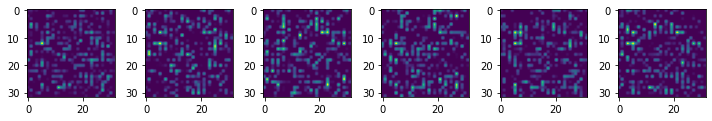

0 0.06912877821326256
1 0.06397041265964508
2 0.0638571587383747
3 0.06379244762063026
4 0.06370562465190888
5 0.06363639458417893
6 0.06357793428301811
7 0.06351850517988204
8 0.06346466866731644
9 0.0634200877904892
10 0.06338024307489395
11 0.06334674648046494
12 0.06330410425662994
13 0.06327583206892014
14 0.06324485548734665
15 0.06321318716406822
16 0.06318117645978928
17 0.06315742482542992
18 0.06313436537981033
19 0.06311434720754623


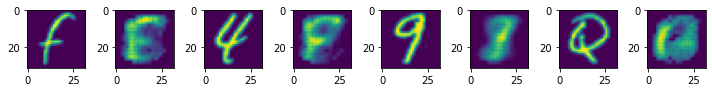

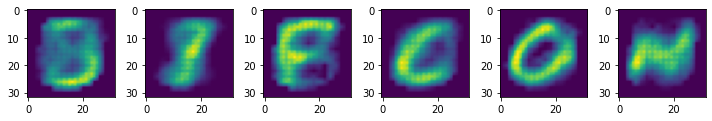

20 0.06309032429456711
21 0.06306996834874153
22 0.06305273498296737
23 0.06303395998477936
24 0.06301636716127396
25 0.06300453338623047
26 0.06298479928970337
27 0.06296608891487121
28 0.0629508272409439
29 0.06292984846830368
30 0.06233444628715515
31 0.062172600764036176
32 0.0621589575111866
33 0.06215138474702835
34 0.062145019662380216
35 0.06213989751338959
36 0.06213542641401291
37 0.06213086045384407
38 0.06212685762047768
39 0.06212253122329712


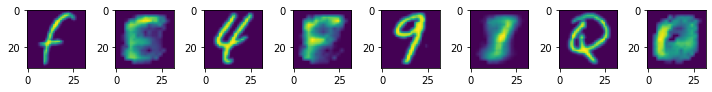

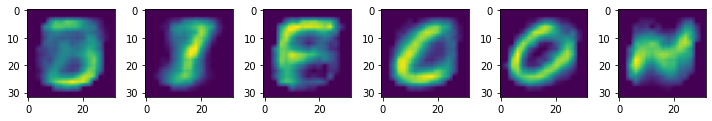

40 0.06211820021271706
41 0.06211394009590149
42 0.06210953235626221
43 0.06210532886981964
44 0.06210087031722069
45 0.06209599841237068
46 0.06209180427193642
47 0.06208760085701943
48 0.0620832925260067
49 0.06207888962626457
50 0.062074499762058255
51 0.06207043622136116
52 0.06206555874943733
53 0.062061634707450866
54 0.06205674902200699
55 0.06205208805799484
56 0.062047766351699826
57 0.06204303393959999
58 0.062038346660137175
59 0.06203377258777618


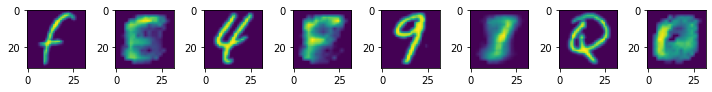

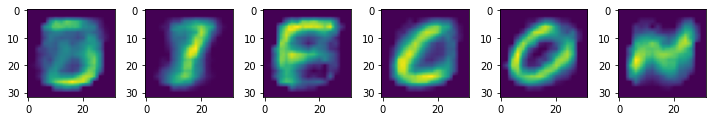

60 0.06193937007188797
61 0.061921850287914276
62 0.06191787986755371
63 0.06191578176021576
64 0.061914351177215575
65 0.06191317903995514
66 0.06191218299865723
67 0.06191124143600464
68 0.061910341477394104
69 0.0619094782948494
70 0.06190865467786789
71 0.06190779011249542
72 0.061906990349292756
73 0.06190616842508316
74 0.06190536062121391
75 0.06190455368757248
76 0.061903745675086976
77 0.061902915173768995
78 0.06190210865736007
79 0.06190128809809685


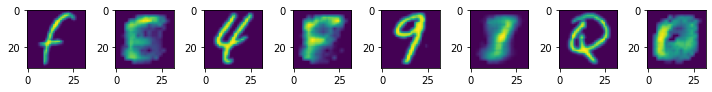

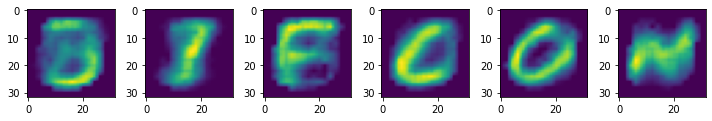

80 0.061900478160381314
81 0.061899654704332355
82 0.06189884481430054
83 0.06189802043437958
84 0.061897215497493746
85 0.06189637680053711
86 0.06189553679227829
87 0.061894714534282684
88 0.061893878108263016
89 0.06189303644895554
90 0.06188090369105339
91 0.061879746222496035
92 0.06187952519655228
93 0.06187939065694809
94 0.061879278767108914
95 0.06187918136715889
96 0.06187908980250358
97 0.06187900356054306
98 0.06187891739010811
99 0.061878833824396136
Finished Training


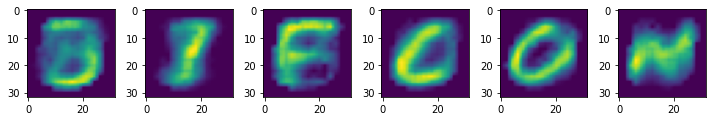

In [13]:
torch.manual_seed(0)

# Train on the entire dataset
attacker = AttackModel().cuda()

hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate')

attacker_hyperparams = hyperparams(
    batch_size=128,
    epochs=100,
    learning_rate=5e-2,
)

# Dataloader
attacker_loader_train = torch.utils.data.DataLoader(attacker_dataset_train, batch_size=attacker_hyperparams.batch_size)

# Optimizer
attack_optim = torch.optim.Adam(attacker.parameters(), lr=attacker_hyperparams.learning_rate)

# Learning Rate Schedule
scheduler = StepLR(attack_optim, step_size=30, gamma=0.1, verbose=False)

for epoch in trange(attacker_hyperparams.epochs):
    epoch_loss = 0.0

    for batch, (data, targets) in enumerate(attacker_loader_train):
        if not (epoch % 20) and not batch:
            ## Generated images
            reconstruct_samples(attacker)
            attack(attacker)

        data.float()
        # Take the model output intercepted from the target model
        targets = attacker_targets_train[
            batch*attacker_hyperparams.batch_size:
            (batch+1)*attacker_hyperparams.batch_size
            ].float()

        attack_optim.zero_grad()

        # Reconstruct image
        output = attacker(targets.cuda())

        # Compute loss & Backprop
        loss = ((output - data.cuda())**2).mean() # We want our reconstructed image to look as much like the original image as possible
        loss.backward()
        attack_optim.step()

        # Logging/Display training progression
        ## Loss
        epoch_loss += output.shape[0] * loss.item()

    print(epoch, epoch_loss / len(attacker_dataset_train))
    scheduler.step()

print('Finished Training')
attack(attacker)

The letters the model was trained to classify/recognize for each category were "D3FC0N". Appart for the second letter, the other images were quite easy to decypher.

This notebook shows the capacity one has to recover training sets from raw predictions of a model. While an attacker might want to increase the number of parameters of its attack model to facilitate the inversion attack, one also has to consider the cost, either in time or money, associated with the use of the prediction step of the target model.

In [14]:
try:
    r = requests.post("http://flags.fly.dev:5000/score", json=json.dumps({"challenge_id": "inference", "submission": "FLAG{D3FC0N}"}))
    print(r.text)
except requests.exceptions.ConnectionError:
    print("Connection problems. Contact the CTF organizers.")

Nice work. The flag is I9A27S4A3JMUD4LAB0R4E5UM2LONII7GSIKR6MC78DOBFPU9YHBRFI7TTVHZRGXWFUVZD1GE78BX6XR3X5DJ0F30BMIWM}LUXKNVL0987LCO{8QFUIEUYIVBKFRDIKL7.
